In [1]:
#Učitavamo neophodne biblioteke

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
#from datetime import datetime
#from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import Binarizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split 
#from sklearn import tree
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [2]:
#Učitavamo dataset

esa = pd.read_csv("baza_v1.csv", sep=';',  index_col="Redni br.")
esa.head()

,BR,Pol,GodCent,Event,Time,EventCVI,EventIM,EventTu,RODJENJE,GODKraj,...,DG1,DG20,DG2,DG30,DG3,DG40,DG4,TIPHD,GODKraj.1,PL
Redni br.,,,,,,,,,,,,,,,,,,,,,
1,156,1,61.0,0,50.0,0.0,0.0,1.0,10.01.1934,65.0,...,Plasmocytoma,4.0,Insuff renum chr term,4.0,Anaemia sec,4.0,Exitus letalis,BHD,65.0,M
2,166,1,29.0,0,17.0,0.0,0.0,0.0,13.05.1966,30.0,...,VUR,4.0,Insuff renum chr term,4.0,TBC,4.0,meningoencephalitis pneumococcida,AHD,30.0,M
3,287,2,53.0,0,149.0,0.0,1.0,0.0,28.05.1949,64.0,...,Nephrectomiam,4.0,Insuff renum chr term,4.0,Insuff renum chr term,4.0,Anaemia sec,BHD,64.0,Z
4,350,1,63.0,0,139.0,0.0,0.0,0.0,27.10.1942,71.0,...,Glomerolonephritis,4.0,AVF,4.0,HBV,4.0,Stenocardia,BHD,71.0,M
5,372,2,52.0,0,74.0,0.0,0.0,0.0,30.10.1955,58.0,...,Renes policystici,4.0,Hypertensio art,4.0,Hepatitis,4.0,Th Pegasys,HDF,58.0,Z


In [3]:
#Pregled kolona dataseta

esa.columns

Index(['BR', 'Pol', 'GodCent', 'Event', 'Time', 'EventCVI', 'EventIM',
       'EventTu', 'RODJENJE', 'GODKraj', 'HD_PRVA', 'HD_CENTAR', 'HD_MES',
       'HDKRAJ', 'DATHDKRAJ', 'ESA', 'Tu', 'MalTu', 'CCI', 'Dg', 'DG1', 'DG20',
       'DG2', 'DG30', 'DG3', 'DG40', 'DG4', 'TIPHD', 'GODKraj.1', 'PL'],
      dtype='object')

In [4]:
#Kolone sa tekstualnim podacima - dijagnozama pretvaramo u tip string
esa['DG1'] = esa["DG1"].astype(str)
esa['DG2'] = esa["DG2"].astype(str)
esa['DG3'] = esa["DG3"].astype(str)
esa['DG4'] = esa["DG4"].astype(str)
esa['HDKRAJ'] = esa["HDKRAJ"].astype(str)
esa["TIPHD"] = esa["TIPHD"].astype(str)

In [5]:
#Kopiramo dataset

esa_1 = esa.copy()
esa_1 = esa_1.drop(['BR','GodCent', 'Event', 'Time', 'RODJENJE', 'GODKraj',
                   'HD_PRVA', 'HD_CENTAR',"HDKRAJ", 'DATHDKRAJ', 'GODKraj.1', "PL"], axis=1)
esa_1[["HD_MES", "Tu", "MalTu"]].fillna(0)
esa_1['TIPHD'].fillna("NNN")
esa_1 = esa_1.dropna()


In [6]:
#Brišemo kolone koje nisu od direktne važnosti za rad

esa_1["ESA"].value_counts()

1.0    219
0.0    172
Name: ESA, dtype: int64

In [7]:
#Koristimo klasu lebelEncoder-a za rad sa više kolona

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        #Transforms columns of X specified in self.columns using LabelEncoder(). 
        #If no columns specified, transforms all columns in X.
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [8]:
#Vršimo trasnformaciju tekstualnih (kolona sa dijagnozama) u numeričke, kako bi mogli da ih 
#koristimo za rad
 
transforming_data = MultiColumnLabelEncoder(columns = ['DG1', 'DG2', 'DG3', 'DG4', "TIPHD"]).fit_transform(esa_1)
transforming_data.head()

,Pol,EventCVI,EventIM,EventTu,HD_MES,ESA,Tu,MalTu,CCI,Dg,DG1,DG20,DG2,DG30,DG3,DG40,DG4,TIPHD
Redni br.,,,,,,,,,,,,,,,,,,
1,1,0.0,0.0,1.0,49.0,0.0,1.0,1.0,7.0,8.0,30,4.0,23,4.0,5,4.0,35,1
2,1,0.0,0.0,0.0,15.0,0.0,0.0,0.0,2.0,8.0,41,4.0,23,4.0,87,4.0,136,0
3,2,0.0,1.0,0.0,135.0,1.0,0.0,0.0,5.0,9.0,23,4.0,23,4.0,58,4.0,6,1
4,1,0.0,0.0,0.0,124.0,0.0,0.0,0.0,6.0,1.0,12,4.0,0,4.0,42,4.0,106,1
5,2,0.0,0.0,0.0,59.0,1.0,0.0,0.0,5.0,3.0,34,4.0,19,4.0,48,4.0,115,2


In [9]:
#Izdvajamo kolone koje ćemo koristiti u Random Forest algoritmu

final_data = transforming_data[['Pol','HD_MES', 'EventCVI', 'EventIM', 'EventTu', 'Tu', 'MalTu', 'CCI', 'Dg', 'DG1', 
                                'DG20', 'DG2', 'DG30', 'DG3', 'DG40', 'DG4', "TIPHD"]]
final_data.head()

,Pol,HD_MES,EventCVI,EventIM,EventTu,Tu,MalTu,CCI,Dg,DG1,DG20,DG2,DG30,DG3,DG40,DG4,TIPHD
Redni br.,,,,,,,,,,,,,,,,,
1,1,49.0,0.0,0.0,1.0,1.0,1.0,7.0,8.0,30,4.0,23,4.0,5,4.0,35,1
2,1,15.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,41,4.0,23,4.0,87,4.0,136,0
3,2,135.0,0.0,1.0,0.0,0.0,0.0,5.0,9.0,23,4.0,23,4.0,58,4.0,6,1
4,1,124.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,12,4.0,0,4.0,42,4.0,106,1
5,2,59.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,34,4.0,19,4.0,48,4.0,115,2


In [10]:
#Određujemo lebel i atribute

y_var = final_data["DG40"]
x_var = final_data[['Pol','HD_MES', 'EventCVI', 'EventIM', 'EventTu','Tu', 'MalTu', 
                    'CCI', 'Dg', 'DG1', 'DG20', 'DG2', 'DG30', 'DG3','TIPHD']]

In [11]:
#Train test split podela dataseta

X_train, X_test, y_train, y_test = train_test_split(x_var, y_var, test_size=0.2, random_state=0)

### Rendom forest Classifier

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x_var, y_var, test_size=0.2, random_state=0)
rfc = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=100)
model_rfc = rfc.fit(X_train, y_train)
model_rfc.score(X_test, y_test)


0.9113924050632911

In [13]:
#Primenjujemo RandomForestClassifier sa nekoliko estimatora kako bi dobili što bolji rezultat
rezultat_rfc = {}
estimators = [100, 150, 200, 250, 300]
for item in estimators:
    rf = RandomForestClassifier(n_estimators=item, max_depth=10)
    model_rfc = rf.fit(X_train, y_train)
    rezultat_rfc[item] = (model_rfc.score(X_test, y_test))

prikaz = pd.DataFrame.from_dict(rezultat_rfc, orient='index').rename(columns={0: 'Rezultat RFC'})
prikaz_rezultat_rfc = prikaz.sort_values(by="Rezultat RFC", ascending=False)
prikaz_rezultat_rfc

,Rezultat RFC
100,0.911392
150,0.911392
200,0.911392
250,0.911392
300,0.911392


In [14]:
#Koristimo GradientBoostingClassifier za finu optimizaciju rezultata.
#GradientBoostingClassifier se koristi kod  metoda klasifikacije

gb = GradientBoostingClassifier()
model_rfc_gb = gb.fit(X_train, y_train)
#model_rfc_gb
model_rfc_gb.score(X_test, y_test)

0.9113924050632911

In [15]:
#crossvalidation
hyperparameters = {
                   "max_depth": randint(3, 6),
                   "max_features": randint(1, 10),
                   "min_samples_leaf": randint(1, 10)
                  }

In [16]:
clf = RandomizedSearchCV(model_rfc, hyperparameters, cv=5)

clf.fit(X_train, y_train)

print("GB Score after CV: %s" % clf.score(X_test, y_test))

C:\Users\Filip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GB Score after CV: 0.9113924050632911


In [17]:
m_rfc = model_rfc.feature_importances_

In [18]:
col = ['Pol','HD_MES', 'EventCVI', 'EventIM', 'EventTu', 'Tu', 'MalTu', 'CCI', 
       'Dg', 'DG1', 'DG20', 'DG2', 'DG30', 'DG3', 'TIPHD']

In [19]:

pd.set_option("precision", 5)
uticaj_rfc_DG20 = pd.DataFrame({"Najbitnije karakteristike": col, "Izmeren uticaj": m_rfc} )
uticaj_rfc_DG20.sort_values("Izmeren uticaj", ascending = False)


,Najbitnije karakteristike,Izmeren uticaj
1,HD_MES,0.17359
13,DG3,0.16565
9,DG1,0.13405
11,DG2,0.12972
8,Dg,0.09734
7,CCI,0.08817
3,EventIM,0.05752
14,TIPHD,0.03786
0,Pol,0.03649
2,EventCVI,0.03593


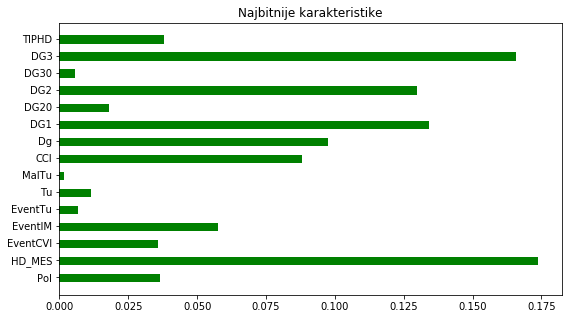

<Figure size 720x720 with 0 Axes>

In [20]:
y_rfc = model_rfc.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.5 
ind = np.arange(len(y_rfc)) 
ax.barh(ind, y_rfc, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Najbitnije karakteristike')
plt.figure(figsize=(10,10))
fig.set_size_inches(9, 5, forward=True)
plt.show()